## Project: Estimation of accuracy of MOI for MVCs 
Created by: Thomas Hartka, MD, MSDS  
Date created: 12/2/21 
  
This notebook determines overall characteristics of the patient population for Table 1.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import itertools

## Read in data

In [2]:
mvcs = pd.read_csv("../Data/NASS_CISS-2000_2019-unfiltered.csv")
mvcs_imp = pd.read_csv("../Data/NASS_CISS-2000_2019-imputated.csv")

In [3]:
mvcs_2000_2009 = mvcs[mvcs.year<=2009]
mvcs_2010_2019 = mvcs[mvcs.year>=2010]

In [4]:
mvcs.columns

Index(['age', 'prop_restraint', 'any_restraint', 'abdeply', 'dvtotal',
       'splimit', 'multicoll', 'pdof_nearside', 'rolled', 'roll_turns',
       'int18', 'int12occ', 'ejection', 'other_death', 'entrapment', 'casewgt',
       'dataset', 'died', 'mais', 'mais3', 'year', 'iss16'],
      dtype='object')

In [5]:
# variables to report
variables = ['age','int12occ','int18','ejection','other_death','any_restraint',
             'splimit','abdeply','multicoll','rolled','entrapment','iss16']

## Functions to descibe data

In [6]:
def stat_continuous_median(df, variable, sigdig=2, quartiles=True):
    '''
    Creates text with median and IQR for continuous variables.
    Inputs:
        df - dataframe with data
        variable - column to analyze
        sigdig - number of significant digits
    Output:
        Returns text with results
    '''
    # extract data
    data = df[variable]
    
    # calc stats
    median = data.median()
    
    # if using quartiles
    if quartiles:
        IQR = data.quantile([0.25,0.75])
        
        # convert to text
        text = str(round(median, sigdig)) +" (" + str(round(IQR[0.25], sigdig)) +"-" + str(round(IQR[0.75], sigdig)) + ")"
    
    # else use range
    else:
        range_min = min(data)
        range_max = max(data)
        
        # convert to text
        text = str(round(median, sigdig)) +" (" + str(round(range_min, sigdig)) +"-" + str(round(range_max, sigdig)) + ")"
    
    return text

In [7]:
def stat_continuous_mean(df, variable, sigdig=2):
    '''
    Creates text with mean and standard deviation for continuous variables.
    Inputs:
        df - dataframe with data
        variable - column to analyze
        sigdig - number of significant digits
    Output:
        Returns text with results
    '''
    # extract data
    data = df[variable]
    
    # calc stats
    mean = data.mean()
    sd = np.std(data)
    
    # convert to text
    text = str(round(mean, sigdig)) +" (" + str(round(sd, sigdig)) + ")"
    
    return text

In [8]:
def stat_binary(df, variable, sigdig=2):
    '''
    Creates text with median and IQR for binary variables.
    Inputs:
        df - dataframe with data
        variable - column to analyze
        sigdig - number of significant digits
    Output:
        Returns text with results
    '''
    # extract data
    data = df[variable]
    
    # calc stats
    pos_count = data[data==1].count()
    pos_perc = pos_count / data.count()
    
    # convert to text
    text = str(round(pos_count, sigdig)) +" (" + str(round(pos_perc*100, sigdig)) + "%)"
    
    return text

In [9]:
def analyze_col(variable, sigdig=2, quartiles=True):
    '''
    Creates text results for a column of data.  This determines if the data
     is binary or continuous, then gets the results for all patients and 
     those with and without severe injury.
    Inputs:
        variable - column to analyze
        sigdig - number of significant digits
    Output:
        Returns list of strings with results [variable, total, non-severe, severe]
    '''
    results = [variable]
       
    # check if binary    
    if all([i in [0,1] for i in mvcs_imp[variable].unique()]):
        results += [stat_binary(mvcs, variable, sigdig)]
        results += [stat_binary(mvcs_2000_2009, variable, sigdig)]
        results += [stat_binary(mvcs_2010_2019, variable, sigdig)]
        results += [stat_binary(mvcs_imp, variable, sigdig)]
        
    else:
        results += [stat_continuous_median(mvcs, variable, sigdig, quartiles)]
        results += [stat_continuous_median(mvcs_2000_2009, variable, sigdig, quartiles)]
        results += [stat_continuous_median(mvcs_2010_2019, variable, sigdig, quartiles)]
        results += [stat_continuous_median(mvcs_imp, variable, sigdig, quartiles)]
        
    return results

In [10]:
def analyze_missing(variable, sigdig):
    
    results = ["missing " + variable]
    
    # find missing
    df = mvcs
    results += [str(len(df[df[variable].isna()])) +" (" + str(round(len(df[df[variable].isna()])/len(df)*100, sigdig)) + "%)"]
    df = mvcs_2000_2009
    results += [str(len(df[df[variable].isna()])) +" (" + str(round(len(df[df[variable].isna()])/len(df)*100, sigdig)) + "%)"]
    df = mvcs_2010_2019
    results += [str(len(df[df[variable].isna()])) +" (" + str(round(len(df[df[variable].isna()])/len(df)*100, sigdig)) + "%)"]
    results += ["n/a"]
   
    return results

In [11]:
analyze_missing('age',1) 

['missing age', '2432 (1.6%)', '1877 (1.8%)', '555 (1.1%)', 'n/a']

## Describe occupants - CISS + NASS

In [16]:
# empty table for results
table = pd.DataFrame(columns=['Variable','Total','2000-2009','2010-2019','Imputed'])

table = table.append(pd.Series(["N", len(mvcs), len(mvcs_2000_2009), len(mvcs_2010_2019), len(mvcs_imp)],index=table.columns), ignore_index=True)

# loop through all variables
for var in variables:
    
    # get results for particular variable
    result = analyze_col(var, 1, quartiles=True)
    
    # add results to table
    table = table.append(pd.Series(result,index=table.columns),ignore_index=True)
    
    # get missingness
    missing = analyze_missing(var,1)
    
    # add percent missing
    table = table.append(pd.Series(missing, index=table.columns),ignore_index=True)

# print table
table.set_index('Variable')

,Total,2000-2009,2010-2019,Imputed
Variable,,,,
N,150683,101919,48764,753415
age,30.0 (20.0-46.0),29.0 (19.0-45.0),32.0 (22.0-50.0),30.0 (20.0-46.0)
missing age,2432 (1.6%),1877 (1.8%),555 (1.1%),n/a
int12occ,6994 (5.1%),5206 (5.1%),1788 (5.2%),35045 (4.7%)
missing int12occ,14208 (9.4%),0 (0.0%),14208 (29.1%),n/a
int18,7973 (5.7%),5166 (5.1%),2807 (7.5%),39875 (5.3%)
missing int18,11550 (7.7%),0 (0.0%),11550 (23.7%),n/a
ejection,5885 (3.9%),4079 (4.0%),1806 (3.7%),29425 (3.9%)
missing ejection,0 (0.0%),0 (0.0%),0 (0.0%),n/a


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c30ecc978>]],
      dtype=object)

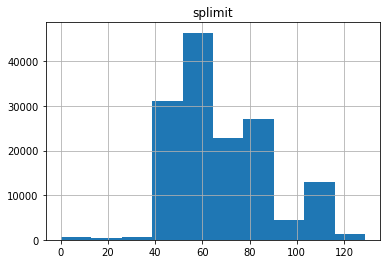

In [14]:
mvcs.hist(column='splimit')

In [15]:
mvcs.splimit.quantile([0,0.25,0.5,0.75,1.0])

0.00      0.0
0.25     56.0
0.50     64.0
0.75     89.0
1.00    129.0
Name: splimit, dtype: float64